# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S9

## Panel a

In [2]:
import pandas as pd
weights_2ndor_spreg = pd.read_csv(path+'Fig6/FYN_suppressor_mochi_order2_sparse_regularized/task_4/weights/weights_Folding.txt', sep='\t')

weights_2ndor_spreg.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in weights_2ndor_spreg.iterrows():
    if row.id_ref == 'WT':
        weights_2ndor_spreg.at[index,'order']=0
    else:
        weights_2ndor_spreg.at[index,'order']=len(row.id.split('_'))


/var/folders/32/dtq6y36s6mjg1zcf2_9dskdm0000gn/T/ipykernel_9184/3456112449.py:54: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((col, row), 1, 1, fill=True,edgecolor='black', lw=0.0001, color='black'))


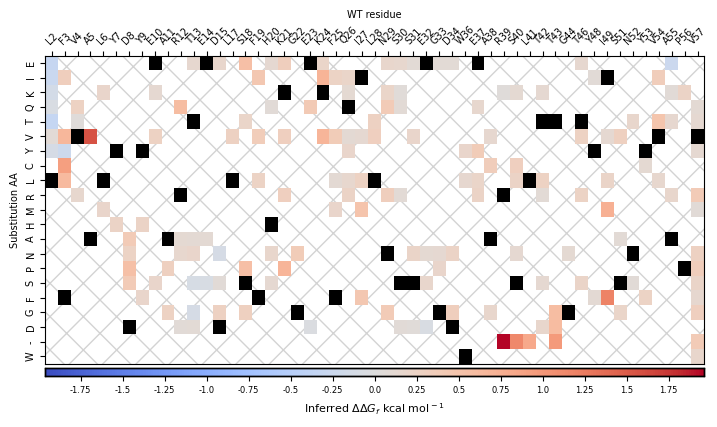

In [3]:
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

firstorderterms=weights_2ndor_spreg.loc[weights_2ndor_spreg['order']==1].copy()

for index, row in firstorderterms.iterrows():
    firstorderterms.at[index,'mut_from']=row.id[0:-1]
    firstorderterms.at[index,'mut_to']=row.id[-1]

mutated_positions = []

for index, row in firstorderterms.iterrows():
    if row.id !='WT' and row.mut_from not in mutated_positions:
        mutated_positions.append(row.mut_from)

coefs_hm=pd.DataFrame(columns=mutated_positions)

for index, row in firstorderterms.iterrows():
    if row.id !='WT':
        coefs_hm.at[row.mut_to,row.mut_from]=row.mean_kcal_mol

singles_boundary=abs(coefs_hm).fillna(0).to_numpy().max()
fig, ax = plt.subplots(figsize=(8.5,4))
cbar_ax=fig.add_axes([0.125,0.08,0.775,0.02])
#ax=sns.heatmap(coefs_hm.fillna(0), cmap='coolwarm', vmin=-1*max(coefs_hm.fillna(0).max()), vmax=max(coefs_hm.fillna(0).max()),cbar_kws={"orientation": "horizontal", "pad": 0.02, 'location':'bottom'}, xticklabels=True, yticklabels=True)
#ax=sns.heatmap(coefs_hm.fillna(np.nan), mask=coefs_hm.fillna(np.nan).isnull(), cmap=shifted_cmap,cbar_kws={"orientation": "horizontal", "pad": 0.02, 'location':'bottom', 'shrink':0.5}, xticklabels=True, yticklabels=True)
ax=sns.heatmap(coefs_hm.fillna(np.nan), mask=coefs_hm.fillna(np.nan).isnull(), cmap='coolwarm', xticklabels=True, yticklabels=True,cbar_kws={"orientation": "horizontal", "pad": 0.02, 'ticks':list(np.arange(-2,3,1))}, cbar_ax=cbar_ax,ax=ax,
              vmax=singles_boundary,vmin=-1*singles_boundary)
ax.set_facecolor('white')
ax.patch.set(hatch='x', edgecolor='#D3D3D3')
#ax.figure.axes[-1].set_xticks(ticks=np.arange(-2,3,1),labels=np.arange(-2,3,1), fontsize=7)
ax.figure.axes[-1].set_xlabel(r'Inferred ${ΔΔG_{f}}$ \ kcal mol$^-$$^1$', rotation=0, labelpad=5, fontsize=7)
ax.tick_params(axis='both', which='both', labelsize=7, labelbottom = False, bottom=False, top = True, labeltop=True)
ax.tick_params(axis='x', which='both', rotation=45)
ax.set_xlabel('WT residue',  fontsize=7)
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Substitution AA', fontsize=7)
#plt.title('Background-averaged\nmutational effects',fontsize=18)


cbar_ax.set_xlabel(r'Inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', rotation=0, fontsize=8)
cbar_ax.xaxis.set_label_position('bottom')
cbar_ax.set_xticks(np.arange(-1.75,2,0.25), [str(round(i,2)) for i in np.arange(-1.75,2,0.25)], fontsize=6)
for spine in cbar_ax.spines.values():
    spine.set(visible=True,lw=1,edgecolor='black')

for i in mutated_positions:
    for j in mutated_positions:
        if i[0]==j[0]:
            col=coefs_hm.columns.get_loc(i)
            row=coefs_hm.index.get_loc(j[0])
            ax.add_patch(Rectangle((col, row), 1, 1, fill=True,edgecolor='black', lw=0.0001, color='black'))
            
ax.spines[['left','bottom','top','right']].set_visible(True)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Isofolds_2ndordersprsreg_1storderterms.png', dpi=300, bbox_inches = "tight")

## Panel b

### Core mutagenesis 1st order energy model

In [4]:
import pandas as pd
weights_core_mut = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order1/task_1/weights/weights_Folding.txt', sep='\t')

weights_core_mut.rename(columns={'mean_kcal/mol':'core_mut_mean_kcal_mol', 'std_kcal/mol':'core_mut_std_kcal_mol', 'ci95_kcal/mol':'core_mut_ci95_kcal_mol'}, inplace=True)
for index, row in weights_core_mut.iterrows():
    weights_core_mut.at[index,'order']=len(row.id.split('_'))

weights_merger = weights_core_mut[['id','core_mut_mean_kcal_mol','core_mut_std_kcal_mol','core_mut_ci95_kcal_mol']].merge(weights_2ndor_spreg[['id','mean_kcal_mol','std_kcal_mol','ci95_kcal_mol']], left_on='id',right_on='id')


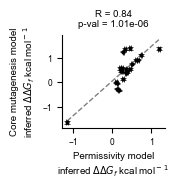

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
plt.rcParams["font.family"] = "Arial"

df = weights_merger.sort_values('mean_kcal_mol').copy()

g = sns.FacetGrid(data=df, aspect=2)
g.map(plt.errorbar, 'mean_kcal_mol', 'core_mut_mean_kcal_mol', 'core_mut_std_kcal_mol','std_kcal_mol', fmt='o', elinewidth=0.5, capsize=2, capthick=0.5, markersize=2, color='k')
#g.add_legend(bbox_to_anchor=(1.3,0.7), title='', fontsize=6)
g.fig.set_size_inches(1.2,1.2)
g.tick_params(axis='both', which='major', labelsize=6)

x = df[['mean_kcal_mol']].to_numpy()
y = df[['core_mut_mean_kcal_mol']].to_numpy()


model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),x.ravel())

plt.plot(x, y_pred, color='Gray', linewidth=1, linestyle='--')
plt.xlabel('Permissivity model\n'+r'inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', fontsize=7)
plt.ylabel('Core mutagenesis model\n'+r'inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', fontsize=7)
plt.title('R = '+str(round(r,2))+'\np-val = {:0.2e}'.format(p), fontsize=7, color='k')

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Permi_vs_1stordercore_model_1storderterms.svg', dpi=300, transparent=True)

### Core mutagenesis 2nd order energy model

In [6]:
import pandas as pd
weights_core_mut = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2/task_1/weights/weights_Folding.txt', sep='\t')

weights_core_mut.rename(columns={'mean_kcal/mol':'core_mut_mean_kcal_mol', 'std_kcal/mol':'core_mut_std_kcal_mol', 'ci95_kcal/mol':'core_mut_ci95_kcal_mol'}, inplace=True)
for index, row in weights_core_mut.iterrows():
    weights_core_mut.at[index,'order']=len(row.id.split('_'))

weights_merger = weights_core_mut[['id','core_mut_mean_kcal_mol','core_mut_std_kcal_mol','core_mut_ci95_kcal_mol','order']].merge(weights_2ndor_spreg[['id','mean_kcal_mol','std_kcal_mol','ci95_kcal_mol']], left_on='id',right_on='id')


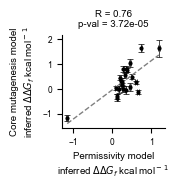

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

df = weights_merger.sort_values('mean_kcal_mol').copy()

g = sns.FacetGrid(data=df.loc[df['order']==1], aspect=2)
g.map(plt.errorbar, 'mean_kcal_mol', 'core_mut_mean_kcal_mol', 'core_mut_std_kcal_mol','std_kcal_mol', fmt='o', elinewidth=0.5, capsize=2, capthick=0.5, markersize=2, color='k')
#g.add_legend(bbox_to_anchor=(1.3,0.7), title='', fontsize=6)
g.fig.set_size_inches(1.2,1.2)
g.tick_params(axis='both', which='major', labelsize=6)

x = df.loc[df['order']==1][['mean_kcal_mol']].to_numpy()
y = df.loc[df['order']==1][['core_mut_mean_kcal_mol']].to_numpy()


model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),x.ravel())

plt.plot(x, y_pred, color='Gray', linewidth=1, linestyle='--')
plt.xlabel('Permissivity model\n'+r'inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', fontsize=7)
plt.ylabel('Core mutagenesis model\n'+r'inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', fontsize=7)
plt.title('R = '+str(round(r,2))+'\np-val = {:0.2e}'.format(p), fontsize=7, color='k')

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Permi_vs_2ndordercore_model_1storderterms.svg', dpi=300, transparent=True)

### Core mutagenesis 2nd order sparse regularized energy model

In [8]:
import pandas as pd
weights_core_mut = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2_sparse_regularized/task_4/weights/weights_Folding.txt', sep='\t')

weights_core_mut.rename(columns={'mean_kcal/mol':'core_mut_mean_kcal_mol', 'std_kcal/mol':'core_mut_std_kcal_mol', 'ci95_kcal/mol':'core_mut_ci95_kcal_mol'}, inplace=True)
for index, row in weights_core_mut.iterrows():
    weights_core_mut.at[index,'order']=len(row.id.split('_'))

weights_merger = weights_core_mut[['id','core_mut_mean_kcal_mol','core_mut_std_kcal_mol','core_mut_ci95_kcal_mol','order']].merge(weights_2ndor_spreg[['id','mean_kcal_mol','std_kcal_mol','ci95_kcal_mol']], left_on='id',right_on='id')


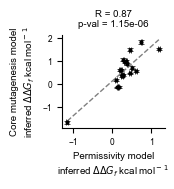

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

df = weights_merger.sort_values('mean_kcal_mol').copy()

g = sns.FacetGrid(data=df.loc[df['order']==1], aspect=2)
g.map(plt.errorbar, 'mean_kcal_mol', 'core_mut_mean_kcal_mol', 'core_mut_std_kcal_mol','std_kcal_mol', fmt='o', elinewidth=0.5, capsize=2, capthick=0.5, markersize=2, color='k')
#g.add_legend(bbox_to_anchor=(1.3,0.7), title='', fontsize=6)
g.fig.set_size_inches(1.2,1.2)
g.tick_params(axis='both', which='major', labelsize=6)

x = df.loc[df['order']==1][['mean_kcal_mol']].to_numpy()
y = df.loc[df['order']==1][['core_mut_mean_kcal_mol']].to_numpy()


model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),x.ravel())

plt.plot(x, y_pred, color='Gray', linewidth=1, linestyle='--')
plt.xlabel('Permissivity model\n'+r'inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', fontsize=7)
plt.ylabel('Core mutagenesis model\n'+r'inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', fontsize=7)
plt.title('R = '+str(round(r,2))+'\np-val = {:0.2e}'.format(p), fontsize=7, color='k')

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Permi_vs_2ndordersprsregcore_model_1storderterms.svg', dpi=300, transparent=True)